In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Install required packages
!pip install langdetect
!pip install nltk
!pip install sbnltk
!pip install textblob
!pip install imblearn
!pip install gensim

# Import text processing libraries
import pandas as pd
import re
import string
from langdetect import detect
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sbnltk.Stemmer import stemmerOP
from sbnltk.Preprocessor import preprocessor
from sbnltk.Tokenizer import wordTokenizer, sentenceTokenizer
from textblob import TextBlob
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# Load data
df = pd.read_excel('/content/drive/MyDrive/TechTalentAssignment/Data & Topics.xlsx')
df.drop_duplicates(inplace=True)
print(f"Dataset shape after removing duplicates: {df.shape}")

# Define text processing functions
# Emoji removal pattern
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # Emoticons
    u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
    u"\U0001F680-\U0001F6FF"  # Transport & Map
    u"\U0001F1E0-\U0001F1FF"  # Flags
    u"\U00002700-\U000027BF"  # Dingbats
    u"\U0001F900-\U0001F9FF"  # Supplemental symbols
    u"\U0001FA70-\U0001FAFF"  # Extended-A (🫵)
    u"\U00002600-\U000026FF"  # Misc symbols
    u"\U0001F000-\U0001F02F"  # Mahjong
    u"\U0000203C"             # Double exclamation
    u"\uFE0F"                 # Variation Selector-16
    "]+",
    flags=re.UNICODE
)

# Custom punctuation (Bangla, Urdu, Arabic)
custom_punct = '।॥''""…،؛؟'
all_punct = string.punctuation + custom_punct

# Load stopwords
en_stop = set(stopwords.words('english'))

# Initialize processors
en_lem = WordNetLemmatizer()
bn_preprocessor = preprocessor()
bn_word_tokenizer = wordTokenizer()
bn_stemmer = stemmerOP()

# Detect Bengali characters
def is_bengali(word):
    return bool(re.search(r'[\u0980-\u09FF]', word))

# Clean and preprocess text - returns tokens instead of string
def preprocess_text(text):
    text = str(text)

    # Remove URLs, hashtags, mentions
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"@\w+", "", text)

    # Remove emojis
    text = emoji_pattern.sub('', text)

    # Remove punctuations
    text = re.sub(f"[{re.escape(all_punct)}]", "", text)

    # Normalize space
    text = re.sub(r'\s+', ' ', text).strip()

    try:
        lang = detect(text)
    except:
        lang = 'en'

    # For Bengali text, use SBNLTK tokenizer
    if (lang == 'bn'):
        try:
            text = bn_preprocessor.word_normalize(text)
            # Tokenize into words
            tokens = bn_word_tokenizer.basic_tokenizer(text)

            # Apply stemming to each token
            tokens = [bn_stemmer.stemWord(t) for t in tokens]
            # Apply dust remove to each token
            tokens = [bn_preprocessor.dust_removal(t) for t in tokens]
        except:
            # Fallback to NLTK if SBNLTK fails
            tokens = word_tokenize(text)
            tokens = [t.lower() for t in tokens if t.isalpha()]
    else:
        # For English, use NLTK with TextBlob correction
        try:
            textBlb = TextBlob(text)
            textBlb = textBlb.correct()
            text = textBlb.string
        except:
            # If TextBlob correction fails
            pass

        # Tokenize into words
        tokens = word_tokenize(text)
        tokens = [t.lower() for t in tokens if t.isalpha()]

    clean_tokens = []
    for token in tokens:
        if is_bengali(token):
            # Bengali tokens are already preprocessed and stemmed
            clean_tokens.append(token)
        else:
            if token not in en_stop:
                lemma = en_lem.lemmatize(token)
                clean_tokens.append(lemma)

    # Return tokens for Word2Vec
    return clean_tokens

# Apply preprocessing to data
print("Applying text preprocessing...")
df['tokens'] = df['Context'].apply(preprocess_text)

# Remove empty documents after cleaning
df = df[df['tokens'].apply(lambda x: len(x) > 0)]
print(f"Dataset shape after removing empty documents: {df.shape}")

# Check class distribution
print("\nChecking class distribution...")
class_counts = df['Training Topic'].value_counts()
print(class_counts)

# Filter out classes with very few samples
print("\nFiltering classes with fewer than 5 samples...")
valid_classes = class_counts[class_counts >= 5].index
filtered_df = df[df['Training Topic'].isin(valid_classes)]
print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(filtered_df)}")

# Get the new data from filtered dataset
X_tokens = filtered_df['tokens']
y = filtered_df['Training Topic']

# Train Word2Vec model
print("\nTraining Word2Vec model...")
word2vec_model = Word2Vec(
    X_tokens,
    vector_size=100,     # Dimensionality of word vectors
    window=5,           # Context window size
    min_count=2,        # Ignore words with frequency less than this
    sg=1,               # Use skip-gram (1) vs CBOW (0)
    workers=4,          # Number of CPU threads for training
    epochs=10           # Number of iterations over the corpus
)

# Function to create document vectors from token lists
def document_vector(tokens, model):
    # Filter tokens that are in the Word2Vec vocabulary
    tokens = [token for token in tokens if token in model.wv.key_to_index]
    if not tokens:
        # Return zeros if no tokens are in vocabulary
        return np.zeros(model.vector_size)
    # Average the word vectors
    return np.mean(model.wv[tokens], axis=0)

# Create document vectors
print("\nCreating document vectors from Word2Vec...")
X_vecs = np.array([document_vector(tokens, word2vec_model) for tokens in X_tokens])

# Check for and handle NaN values
nan_mask = np.isnan(X_vecs).any(axis=1)
if nan_mask.any():
    print(f"Found {nan_mask.sum()} documents with NaN vectors, replacing with zeros")
    X_vecs[nan_mask] = 0

# Normalize the vectors
print("Normalizing document vectors...")
scaler = StandardScaler()
X_vecs = scaler.fit_transform(X_vecs)

# Now perform the train-test split
print("\nPerforming train-test split...")
X_train, X_test, y_train, y_test = train_test_split(
    X_vecs, y, test_size=0.2, random_state=42, stratify=y
)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Dataset shape after removing duplicates: (551, 3)
Applying text preprocessing...
Dataset shape after removing empty documents: (544, 4)

Checking class distribution...
Training Topic
Mob Justice                   124
Law and Order                  66
Politics                       59
Islamic Fundamentalism         45
International affairs          34
Religion                       33
Corruption                     30
National Defence               27
Diplomacy                      24
Governance & Policy Reform     20
Women Rights                   19
Sports                         15
Terrorism                      12
Election                       11
Culture & Lifestyle            10
Trade & Commodity Price         6
Education                       4
Environment                     2
Natural Disaster                2
Religious Conflict              1
Name: count, dtype: int64

Filtering classes with fewer than 5 samples...
Original dataset size: 544
Filtered dataset size: 535

Training


Applying balanced sampling strategy...
Undersampling strategy: {'Mob Justice': 24, 'Law and Order': 24, 'Politics': 24, 'Islamic Fundamentalism': 24}
Class counts after undersampling (if applied): Training Topic
International affairs         27
Religion                      26
Islamic Fundamentalism        24
Corruption                    24
Mob Justice                   24
Politics                      24
Law and Order                 24
National Defence              22
Diplomacy                     19
Governance & Policy Reform    16
Women Rights                  15
Sports                        12
Terrorism                     10
Election                       9
Culture & Lifestyle            8
Trade & Commodity Price        5
Name: count, dtype: int64
Using k_neighbors=4 for SMOTE

Class distribution after resampling:
Training Topic
Corruption                    27
Culture & Lifestyle           27
Diplomacy                     27
Election                      27
Governance & Polic

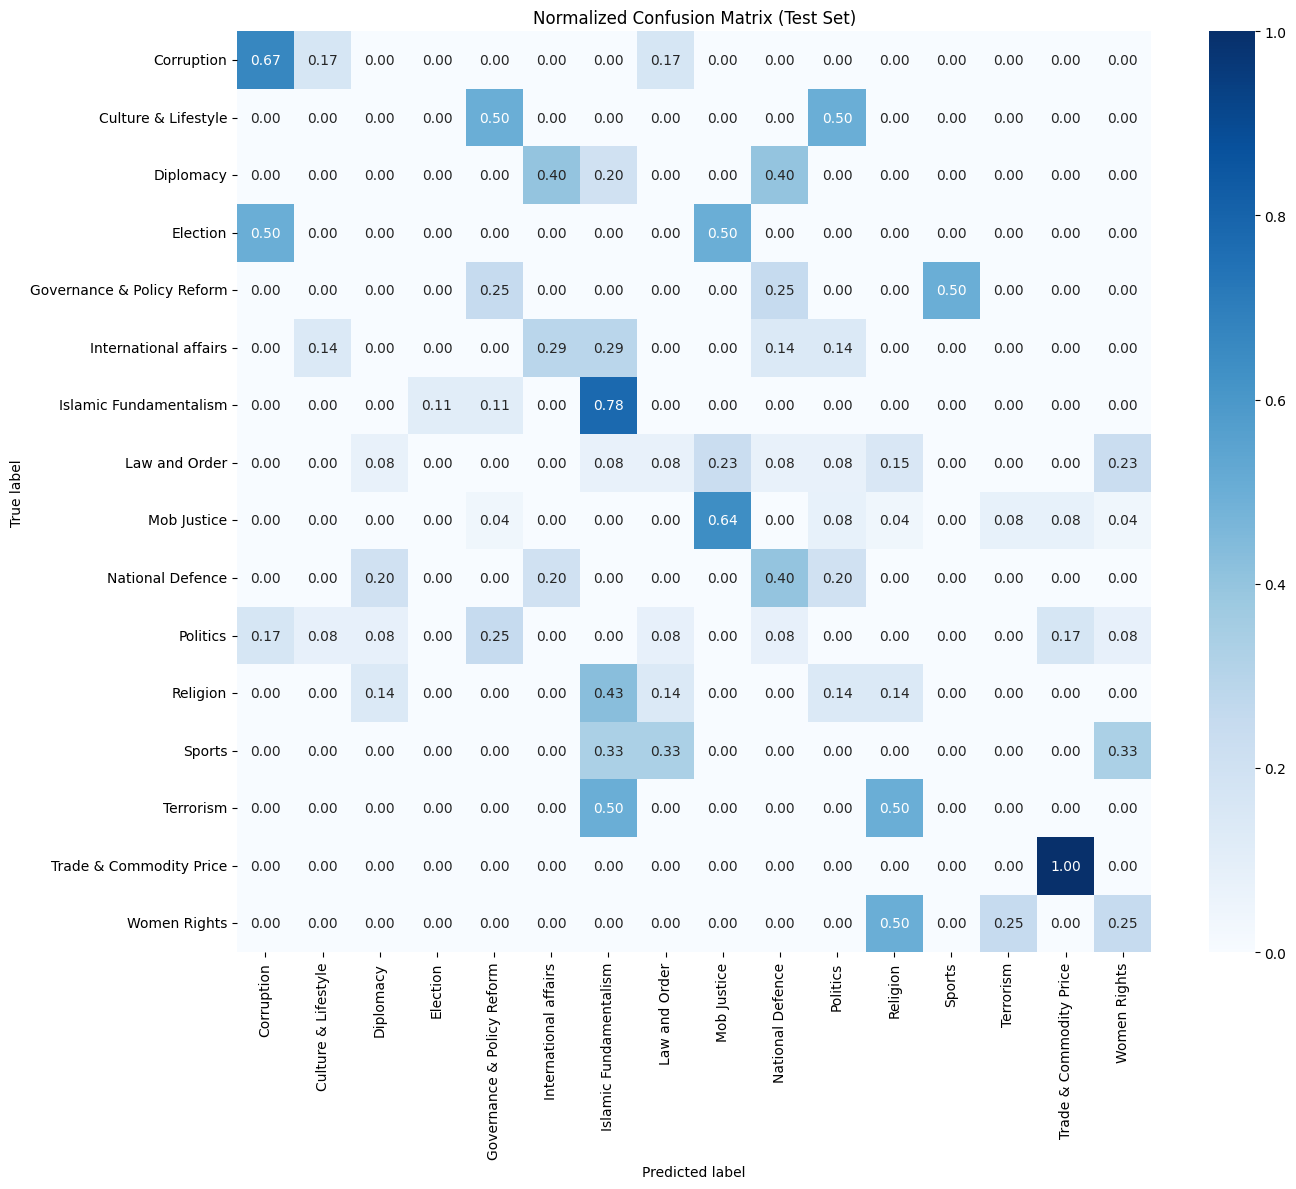


Saving model and vectorization tools...
Model and vectorization tools saved successfully!

Visualizing per-class performance...


<Figure size 1400x1000 with 0 Axes>

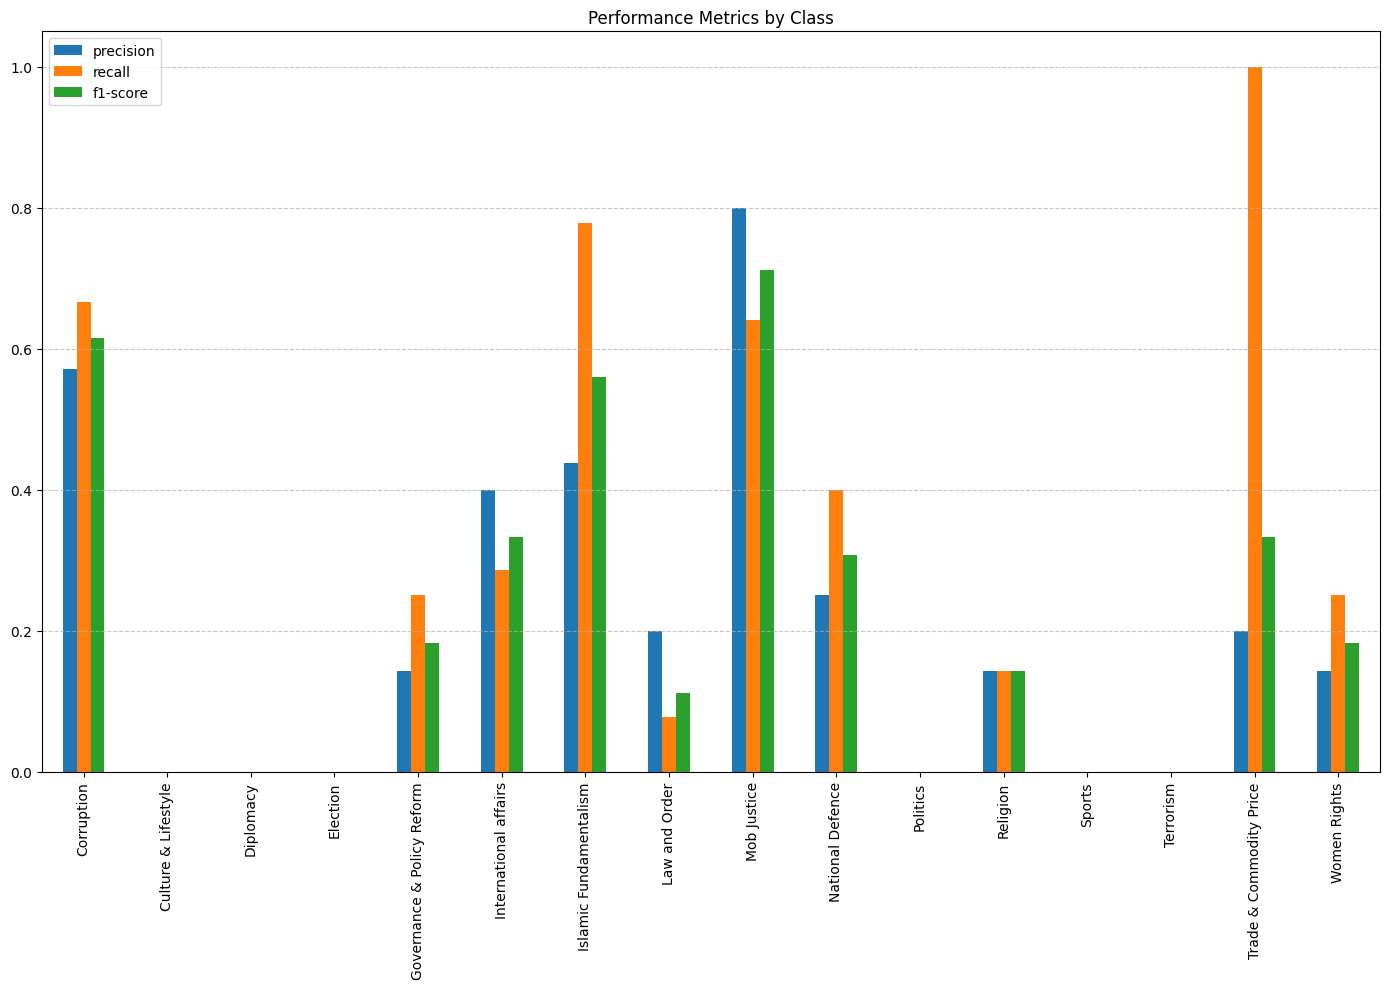


Detailed per-class metrics (sorted by F1-score):
                            precision    recall  f1-score     support
Culture & Lifestyle          0.000000  0.000000  0.000000    2.000000
Diplomacy                    0.000000  0.000000  0.000000    5.000000
Election                     0.000000  0.000000  0.000000    2.000000
Politics                     0.000000  0.000000  0.000000   12.000000
Sports                       0.000000  0.000000  0.000000    3.000000
Terrorism                    0.000000  0.000000  0.000000    2.000000
Law and Order                0.200000  0.076923  0.111111   13.000000
Religion                     0.142857  0.142857  0.142857    7.000000
Women Rights                 0.142857  0.250000  0.181818    4.000000
Governance & Policy Reform   0.142857  0.250000  0.181818    4.000000
macro avg                    0.205469  0.280621  0.217404  107.000000
National Defence             0.250000  0.400000  0.307692    5.000000
weighted avg                 0.339803  0

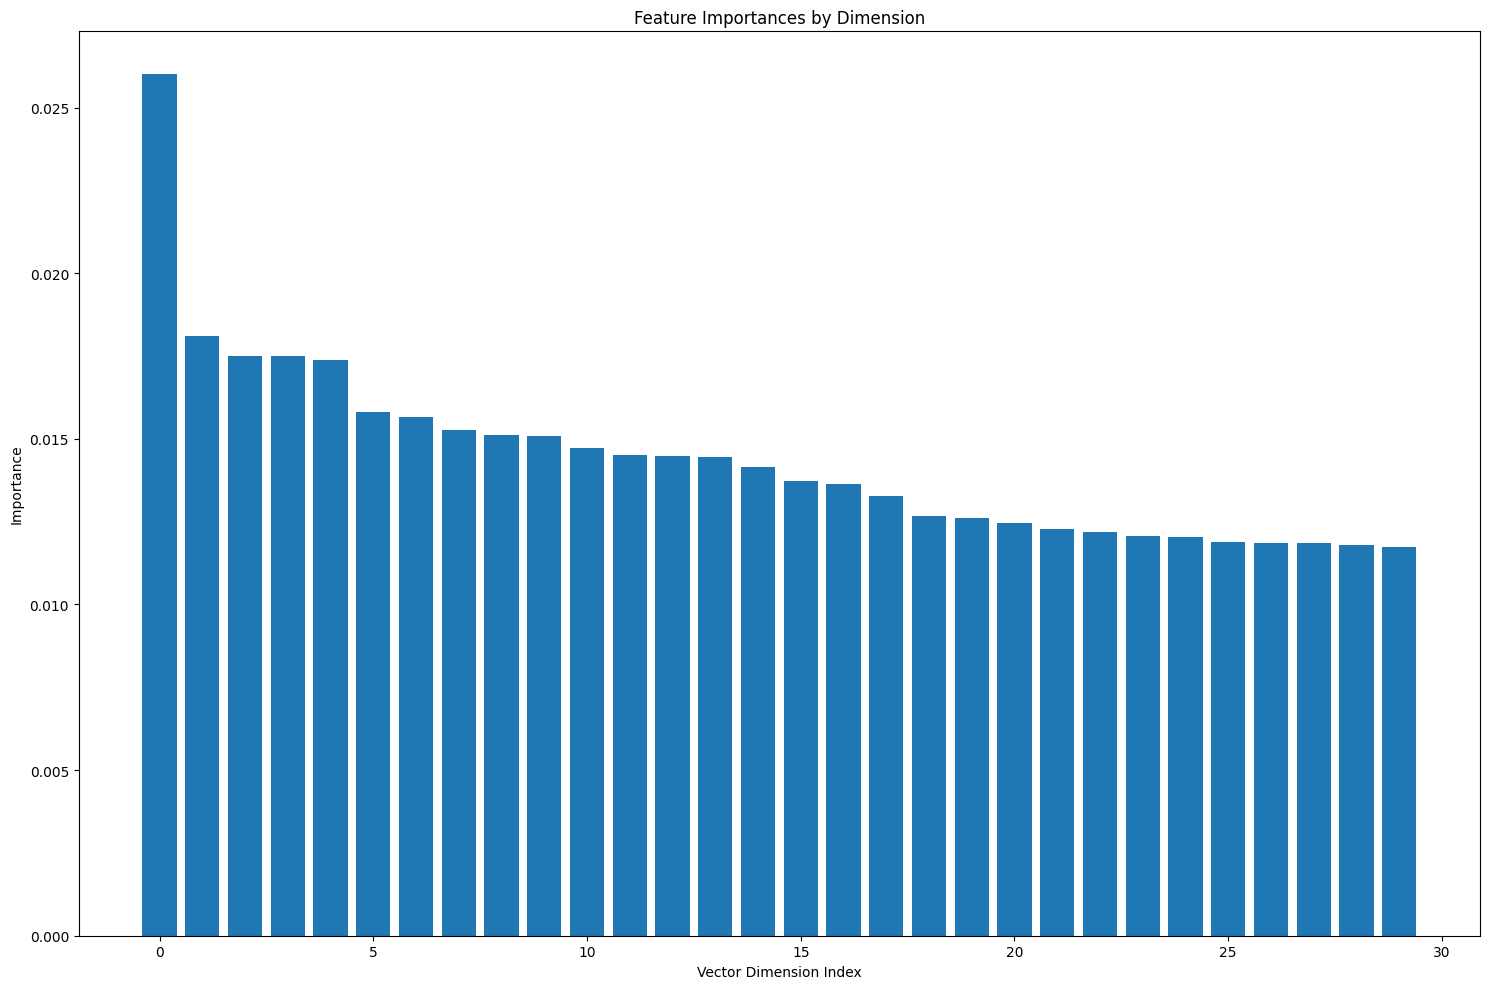


Sample prediction:
Text: 'Police arrested three individuals involved in corruption at the ministry'
Predicted Topic: Culture & Lifestyle
Top 3 predictions:
  Culture & Lifestyle: 0.1654
  Law and Order: 0.1605
  Sports: 0.1374

Performing 5-fold cross-validation...
Cross-validation scores: [0.41121495 0.35514019 0.43925234 0.38317757 0.31775701]
Mean CV accuracy: 0.3813 ± 0.0424

Comparing different models on the Word2Vec features:

Training Random Forest...
Random Forest - Training accuracy: 0.8154, Test accuracy: 0.2617

Training Logistic Regression...
Logistic Regression - Training accuracy: 0.5093, Test accuracy: 0.4112

Training SVM...
SVM - Training accuracy: 0.3575, Test accuracy: 0.3178

Training Gaussian NB...
Gaussian NB - Training accuracy: 0.3435, Test accuracy: 0.3458


In [5]:
# Create a smarter sampling strategy for imbalanced classes
def get_sampling_strategy():
    # Get actual counts in the training set (not the full dataset)
    train_class_counts = pd.Series(y_train).value_counts()

    # Calculate the median class size
    median_size = np.median(list(train_class_counts))
    target_size = int(median_size * 0.8)  # Target around 80% of median size

    strategy = {}
    for class_name, count in train_class_counts.items():
        if count > median_size * 1.5:  # Large classes
            strategy[class_name] = min(count, int(median_size * 1.2))
        elif count < median_size * 0.5 and count >= 5:  # Small classes that need oversampling
            # Skip for undersampling - we'll handle these with SMOTE later
            pass
    return strategy

# Apply balanced sampling
print("\nApplying balanced sampling strategy...")

# First, check what our strategy would be
undersampling_strategy = get_sampling_strategy()
if undersampling_strategy:  # Only use undersampler if we have a non-empty strategy
    print(f"Undersampling strategy: {undersampling_strategy}")
    undersampler = RandomUnderSampler(
        sampling_strategy=undersampling_strategy,
        random_state=42
    )
    # Apply undersampling first
    X_temp, y_temp = undersampler.fit_resample(X_train, y_train)
else:
    print("No undersampling needed, skipping to oversampling")
    X_temp, y_temp = X_train, y_train

# Get counts after potential undersampling
class_counts_after_under = pd.Series(y_temp).value_counts()
print(f"Class counts after undersampling (if applied): {class_counts_after_under}")

# Find the minimum count that's safe for SMOTE's k_neighbors
min_class_count = class_counts_after_under.min()
k_neighbors = min(5, min_class_count - 1)  # k must be <= n_minority - 1
k_neighbors = max(1, k_neighbors)  # Ensure k is at least 1
print(f"Using k_neighbors={k_neighbors} for SMOTE")

# Now apply SMOTE for oversampling the minority classes
oversampler = SMOTE(
    sampling_strategy='not majority',  # Oversample all but the majority class
    random_state=42,
    k_neighbors=k_neighbors
)

# Apply oversampling
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_temp, y_temp)

# Check resampled class distribution
print("\nClass distribution after resampling:")
print(pd.Series(y_train_resampled).value_counts())

# Train a Random Forest model with better hyperparameters
print("\nTraining Random Forest classifier...")
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced_subsample',  # Additional class balancing
    n_jobs=-1,
    random_state=42
)
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
print("Making predictions...")
y_train_pred = model.predict(X_train)  # Predict on original training data
y_test_pred = model.predict(X_test)

# Calculate metrics
print("\n--- Training set evaluation (on original training data) ---")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

print("\n--- Test set evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Generate confusion matrix for test set
print("\nGenerating confusion matrices...")

# Plot normalized confusion matrix for test set
plt.figure(figsize=(14, 12))
cm_test = confusion_matrix(y_test, y_test_pred)
cm_test_normalized = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_test_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Normalized Confusion Matrix (Test Set)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_word2vec.png')
plt.show()

# Save the model and vectorization tools
print("\nSaving model and vectorization tools...")
joblib.dump(model, 'text_classification_model_word2vec.pkl')
word2vec_model.save('word2vec_model.bin')
joblib.dump(scaler, 'scaler_word2vec.pkl')
print("Model and vectorization tools saved successfully!")

# Create a bar chart showing performance metrics per class
print("\nVisualizing per-class performance...")
class_report = classification_report(y_test, y_test_pred, output_dict=True)
class_df = pd.DataFrame(class_report).transpose()
metrics_df = class_df[['precision', 'recall', 'f1-score']].iloc[:-3]  # Remove avg/total rows

plt.figure(figsize=(14, 10))
metrics_df.plot(kind='bar', figsize=(14, 10))
plt.title('Performance Metrics by Class')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('class_performance_word2vec.png')
plt.show()

# Display detailed per-class metrics
print("\nDetailed per-class metrics (sorted by F1-score):")
print(class_df[['precision', 'recall', 'f1-score', 'support']].sort_values(by='f1-score'))

# Display class distribution comparison
print("\nClass counts comparison (original train vs. resampled train vs. test):")
original_train_counts = pd.Series(y_train).value_counts().sort_index()
resampled_train_counts = pd.Series(y_train_resampled).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

comparison_df = pd.DataFrame({
    'Original Train': original_train_counts,
    'Resampled Train': resampled_train_counts,
    'Test': test_counts
}).fillna(0).astype(int)

print(comparison_df)

# Visualize feature importance for top classes
plt.figure(figsize=(15, 10))
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Feature Importances by Dimension')
plt.bar(range(min(30, len(importances))), importances[indices[:30]])
plt.xlabel('Vector Dimension Index')
plt.ylabel('Importance')
plt.tight_layout()
plt.savefig('word2vec_feature_importance.png')
plt.show()

# Function for prediction with new text
def predict_topic(text):
    # Preprocess the text
    tokens = preprocess_text(text)
    # Create document vector
    doc_vec = document_vector(tokens, word2vec_model)
    # Normalize the vector
    doc_vec = scaler.transform([doc_vec])
    # Predict the topic
    prediction = model.predict(doc_vec)[0]
    # Get prediction probabilities
    proba = model.predict_proba(doc_vec)[0]
    # Find top 3 classes
    top3_idx = proba.argsort()[-3:][::-1]
    top3_classes = [model.classes_[i] for i in top3_idx]
    top3_probs = [proba[i] for i in top3_idx]

    return {
        'predicted_topic': prediction,
        'top3_topics': list(zip(top3_classes, top3_probs))
    }

# Demo prediction with sample text
sample_text = "Police arrested three individuals involved in corruption at the ministry"
prediction_result = predict_topic(sample_text)
print("\nSample prediction:")
print(f"Text: '{sample_text}'")
print(f"Predicted Topic: {prediction_result['predicted_topic']}")
print("Top 3 predictions:")
for topic, prob in prediction_result['top3_topics']:
    print(f"  {topic}: {prob:.4f}")

# Cross-validation for more robust evaluation
from sklearn.model_selection import cross_val_score, StratifiedKFold

print("\nPerforming 5-fold cross-validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_vecs, y, cv=skf, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Alternative models evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

print("\nComparing different models on the Word2Vec features:")

# List of models to compare
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(C=1.0, max_iter=1000, random_state=42),
    'SVM': SVC(C=1.0, kernel='rbf', probability=True, random_state=42),
    'Gaussian NB': GaussianNB()
}

# Train and evaluate each model
for name, clf in models.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train_resampled, y_train_resampled)
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    print(f"{name} - Training accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")